# 환경설정

In [17]:
import tensorflow as tf, numpy as np
import keras
import matplotlib.pyplot as plt
import os, time, imageio, glob

from keras import layers
from IPython import display

print(tf.__version__)
print(imageio.__version__)

2.18.0
2.37.0


# 데이터 적재 및 확인

In [18]:
cifar10 = keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

print(f'train_x.shape: {train_x.shape}')
print(f"max_pixel: {train_x.max()}, min_pixel: {train_x.min()}")

train_x.shape: (50000, 32, 32, 3)
max_pixel: 255, min_pixel: 0


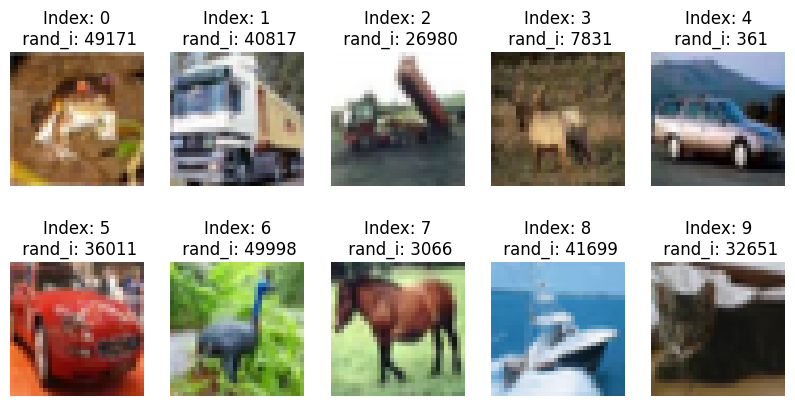

In [19]:
def show_multiple_random_images(dataset, num_images=10, is_normalized=False):
    row_num = num_images // 5
    
    plt.figure(figsize=(10, row_num * 2.5))
    random_indexes = np.random.choice(dataset.shape[0], num_images)

    for i, rand_i in zip(range(num_images), random_indexes):
        plt.subplot(row_num, 5, i+1)
        plt.title(f'Index: {i}\n rand_i: {rand_i}')
        
        if is_normalized:
            image = (dataset[i] + 1) / 2
        else:
            image = dataset[i]
        
        plt.imshow(image)
        plt.axis('off')

    plt.show()

show_multiple_random_images(train_x)

In [20]:
train_x = (train_x - 127.5) / 127.5

In [21]:
print(f"max_pixel: {train_x.max()}, min_pixel: {train_x.min()}")

batch_size = 250
shuffle_buffer_size = 50000

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(shuffle_buffer_size).batch(batch_size)

max_pixel: 1.0, min_pixel: -1.0


# 모델 설정

In [22]:
def init_gen_model():
    model = keras.Sequential()
    model.add(keras.Input(shape=(100,)))
    
    # Dense Layer
    model.add(layers.Dense(8*8*256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Reshape Layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Conv2DTranspose Layer: 8 x 8
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Conv2DTranspose Layer: 8 x 8 => 16 x 16
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Conv2DTranspose Layer: 16 x 16 => 32 x 32
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

generator = init_gen_model()
generator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 16384)          │     1,638,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 8, 8, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 16, 16, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 32, 32, 3)      │         4,800 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,733,504 (10.43 MB)

 Trainable params: 2,700,352 (10.30 MB)

 Non-trainable params: 33,152 (129.50 KB)

In [23]:
noise = tf.random.normal([10, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([10, 32, 32, 3])

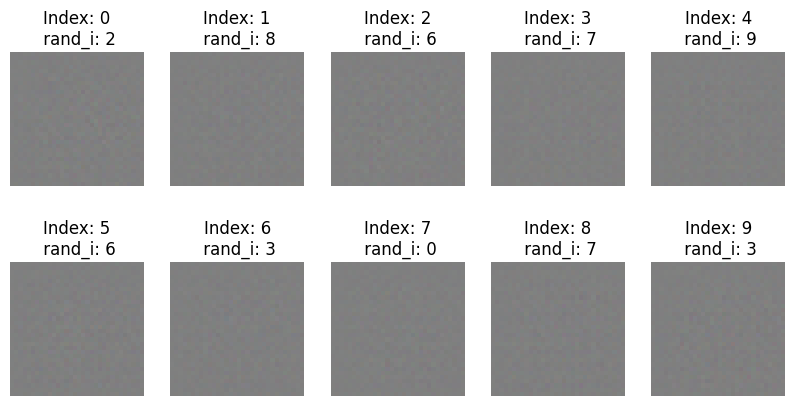

In [24]:
show_multiple_random_images(generated_image, is_normalized=True)

In [25]:
def init_disc_model():
    model = keras.Sequential()
    
    # Conv2D Layer: 32 x 32 => 16 x 16
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Conv2D Layer: 16 x 16 => 8 x 8
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Flatten Layer
    model.add(layers.Flatten())
    
    # Dense Layer
    model.add(layers.Dense(1))
    
    return model

discriminator = init_disc_model()
discriminator.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,985 (851.50 KB)

 Trainable params: 217,985 (851.50 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
decision = discriminator(generated_image)
decision

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[ 0.00573527],
       [ 0.00085083],
       [ 0.00833835],
       [ 0.00016381],
       [ 0.00169734],
       [-0.00112324],
       [ 0.00306777],
       [ 0.00239909],
       [ 0.00266591],
       [ 0.00059266]], dtype=float32)>

In [ ]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(generated_prediction):
    return cross_entropy(tf.ones_like(generated_prediction), generated_prediction)

def discriminator_loss(dataset_prediction, generated_prediction):
    noisy_dataset_prediction = dataset_prediction + 0.1 * tf.random.normal(dataset_prediction.shape)
    noisy_generated_prediction = generated_prediction + 0.1 * tf.random.normal(generated_prediction.shape)
    
    dataset_image_loss = cross_entropy(tf.ones_like(dataset_prediction), noisy_dataset_prediction)
    generated_image_loss = cross_entropy(tf.zeros_like(generated_prediction), noisy_generated_prediction)
    
    return dataset_image_loss + generated_image_loss

def discriminator_accuracy(dataset_prediction, generatged_prediction):
    dataset_prediction_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(dataset_prediction, 0.5), tf.float32))
    generated_prediction_accuracy = tf.reduce_mean(tf.cast(tf.math.less(generatged_prediction, 0.5), tf.float32))
    
    return dataset_prediction_accuracy, generated_prediction_accuracy

generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [28]:
@tf.function
def train_step(dataset_images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        dataset_image_label = discriminator(dataset_images, training=True)
        generated_image_label = discriminator(generated_images, training=True)

        gen_loss = generator_loss(generated_image_label)
        disc_loss = discriminator_loss(dataset_image_label, generated_image_label)

        real_accuracy, fake_accuracy = discriminator_accuracy(dataset_image_label, generated_image_label) 
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy # return values to log

In [29]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)
        plt.axis('off')
    
    plt.savefig(f'{os.getenv('HOME')}/keras/exp_4/generated_samples/image_at_epoch_{epoch:04d}_iter_{it:03d}.png')
    plt.show()

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    # plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  

    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig(f'{os.getenv('HOME')}/keras/exp_4/training_history/train_history_{epoch:04d}.png')
    plt.show()

In [30]:
checkpoint_dir = os.getenv('HOME') + '/keras/exp_4/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [31]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

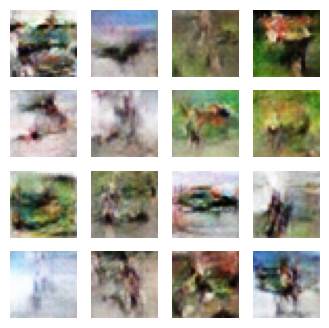

Time for training : 1929 sec


In [ ]:
%%time
train(train_dataset, 500, 5)